# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

[Скачать данные](https://lms-cdn.skillfactory.ru/assets/courseware/v1/9e84f30c5bc84881a5e33262d5e32a8b/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ds_salaries.zip)

Описание столбцов:
| work_year          | Год, в котором была выплачена зарплата.                                                                                                                                                                       |
|--------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| experience_level   | Опыт работы на этой должности в течение года со следующими возможными значениями: <br>EN — Entry-level/Junior; <br>MI — Mid-level/Intermediate; <br>SE — Senior-level/Expert; <br>EX — Executive-level/Director.              |
| employment_type    | Тип трудоустройства для этой роли: <br>PT — неполный рабочий день; <br>FT — полный рабочий день; <br>CT — контракт; <br>FL — фриланс.                                                                                         |
| job_title          | Роль, в которой соискатель работал в течение года.                                                                                                                                                            |
| salary             | Общая выплаченная валовая сумма заработной платы.                                                                                                                                                             |
| salary_currency    | Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.                                                                                                                                            |
| salary_in_usd      | Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).                                                                     |
| employee_residence | Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.                                                                                                                    |
| remote_ratio       | Общий объём работы, выполняемой удалённо. Возможные значения: <br>0 — удалённой работы нет (менее 20 %); <br>50 — частично удалённая работа; <br>100 — полностью удалённая работа (более 80 %).                           |
| company_location   | Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.                                                                                                                      |
| company_size       | Среднее количество людей, работавших в компании в течение года: <br>S — менее 50 сотрудников (небольшая компания); <br>M — от 50 до 250 сотрудников (средняя компания); <br>L — более 250 сотрудников (крупная компания). |

Оригинальный датасет: [“Data Science Job Salaries”](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries "kaggle.com")

### Постановка задачи

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:
   * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
   * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
   * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
   * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

---

### 1. Загрузка и обработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# Исследуем датасет на пропуски и типы данных
data.info()

# Ищем и удаляем дубликаты
print('\nКоличество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


В таблице `607` записей, ропущенных значений нет, дубликатов `42`.
<br> После удаления дубликатов в таблице осталось `565` записей.
<br>Типы данных столбцов корректны. Собственно, все признака с типом данных `'int64'` являются числовыми, остальные с типом `'object'` категориальными.
<br>Признаки `'salary'` и `'salary_currency'` неинформативны и их можно удалить.

In [4]:
# Cтатистические характеристики для числовых признаков
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,565.000000,5.650000e+02,565.000000,565.000000
mean,2021.364602,3.381160e+05,110610.343363,69.911504
std,0.698138,1.599879e+06,72280.702792,40.900666
min,2020.000000,4.000000e+03,2859.000000,0.000000
25%,2021.000000,6.700000e+04,60757.000000,50.000000
50%,2021.000000,1.109250e+05,100000.000000,100.000000
75%,2022.000000,1.650000e+05,150000.000000,100.000000
max,2022.000000,3.040000e+07,600000.000000,100.000000


In [5]:
# Cтатистические характеристики для категориальных признаков
data[data.columns[data.dtypes == 'object']].describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,17,57,50,3
top,SE,FT,Data Scientist,USD,US,US,M
freq,243,546,130,359,295,318,290


---

### 2. Разведывательный анализ данных

#### 2.1. Визуальный анализ данных

##### 2.1a Распределение заработной платы

In [6]:
# часть датасета, относящаяся только с специалистам Data Scientist
ds = data[data['job_title'] == 'Data Scientist']

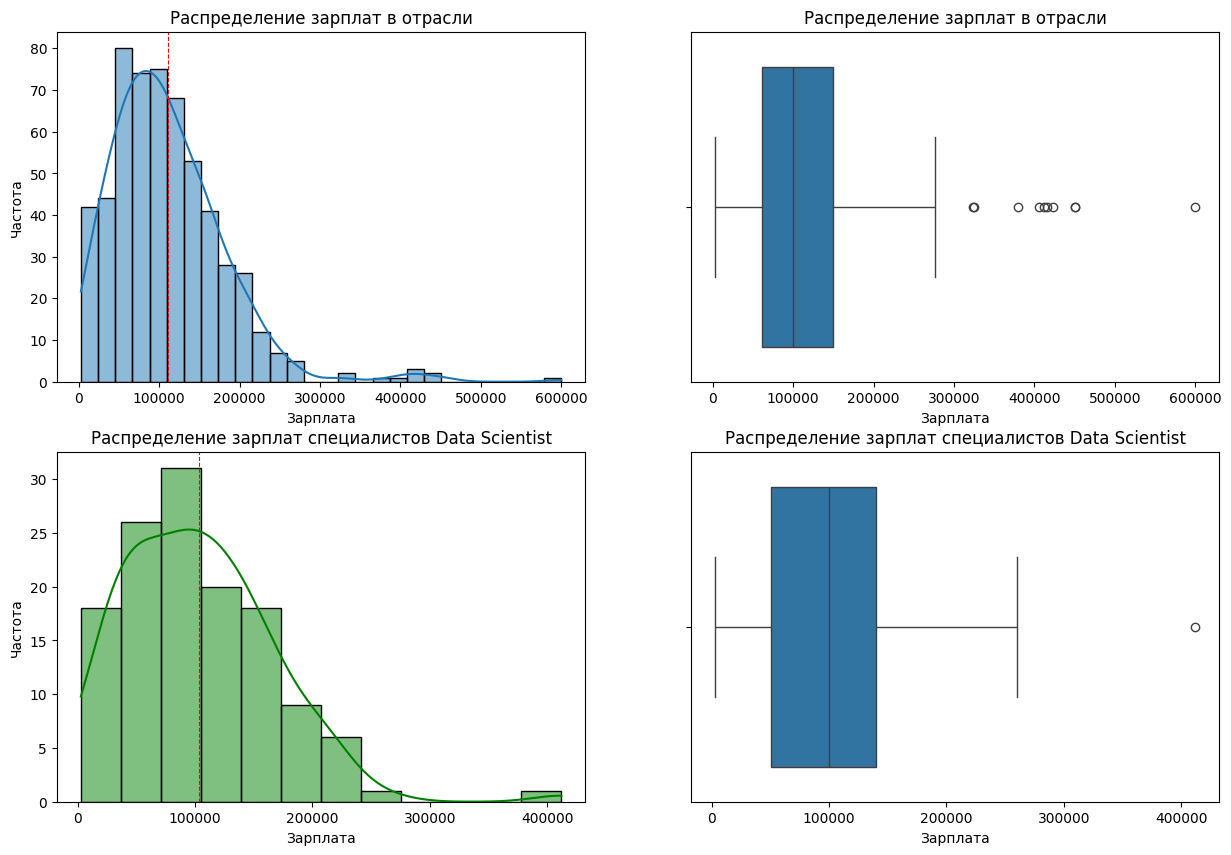

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0,0])
axes[0,0].set(xlabel='Зарплата', ylabel='Частота')
axes[0,0].set_title('Распределение зарплат в отрасли')
axes[0,0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[0,1], orient='h')
axes[0,1].set(xlabel='Зарплата')
axes[0,1].set_title('Распределение зарплат в отрасли')

sns.histplot(ds['salary_in_usd'], kde=True, ax=axes[1,0], color='green')
axes[1,0].set(xlabel='Зарплата', ylabel='Частота')
axes[1,0].set_title('Распределение зарплат специалистов Data Scientist')
axes[1,0].axvline(ds['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(ds['salary_in_usd'], ax=axes[1,1], orient='h')
axes[1,1].set(xlabel='Зарплата')
axes[1,1].set_title('Распределение зарплат специалистов Data Scientist')

plt.show()

Рапределения зарплат отличаются от нормального. Можно заметить, что зарплаты специалистов Data Scientist в среднем выше, чем по отрасли. Для специалистов Data Scientist присутствует только один потенциальный выброс.

##### 2.1b Распределение зарплат специалистов Data Scientist в зависимости от года

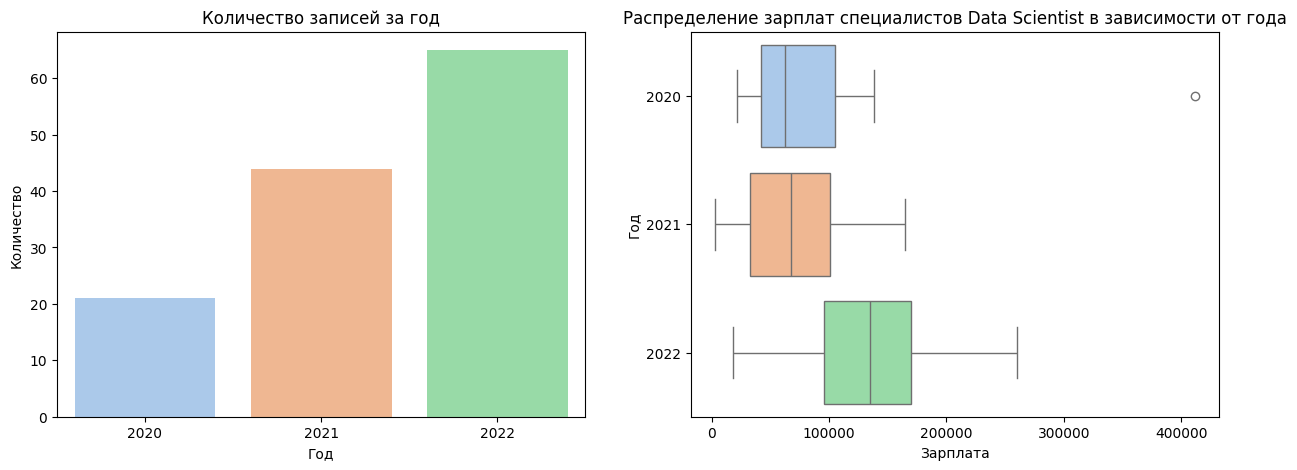

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=ds,
    ax=axes[0], 
    x='work_year', 
    hue='work_year',  
    palette='pastel',
    legend=False
    )
axes[0].set(xlabel='Год', ylabel='Количество')
axes[0].set_title('Количество записей за год')

sns.boxplot(
    data=ds,
    ax=axes[1],
    y='work_year',
    x='salary_in_usd',
    orient='h',
    hue='work_year',
    palette='pastel',
    legend=False
)
axes[1].set_title('Распределение зарплат специалистов Data Scientist в зависимости от года')
axes[1].set_xlabel('Зарплата')
axes[1].set_ylabel('Год')

plt.show()

Можно заметить, что медианная зарплата в 2022 существенно выше, чем в предыдущие два года. Медиана для 2021 тоже немного больше, чем для 2020, хотя отличается размах. Выброс оказался среди данных 2020 год. Но всё равно пока можно предварительно предположить, что ежегодный рост зарплат наблюдается.

In [9]:
ds.groupby('work_year')['salary_in_usd'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.5,81436.6,21669.0,42197.0,62726.0,105000.0,412000.0
2021,44.0,70215.8,45843.8,2859.0,32793.8,67233.5,100922.8,165000.0
2022,65.0,131366.9,55785.2,18442.0,95550.0,135000.0,170000.0,260000.0


Среднее значение зарплаты в 2020 выше, но, судя по всему, на него существенно влияет тот выброс. Если его исключить, то и среднее значение будет меньше, чем в 2021, хотя и не намного.

In [10]:
ds[ds['salary_in_usd'] < 400000].groupby('work_year')['salary_in_usd'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.0,33268.1,21669.0,41768.0,62726.0,94677.8,138350.0
2021,44.0,70215.8,45843.8,2859.0,32793.8,67233.5,100922.8,165000.0
2022,65.0,131366.9,55785.2,18442.0,95550.0,135000.0,170000.0,260000.0


##### 2.1c Распределение зарплат специалистов Data Scientist в зависимости от опыта работы

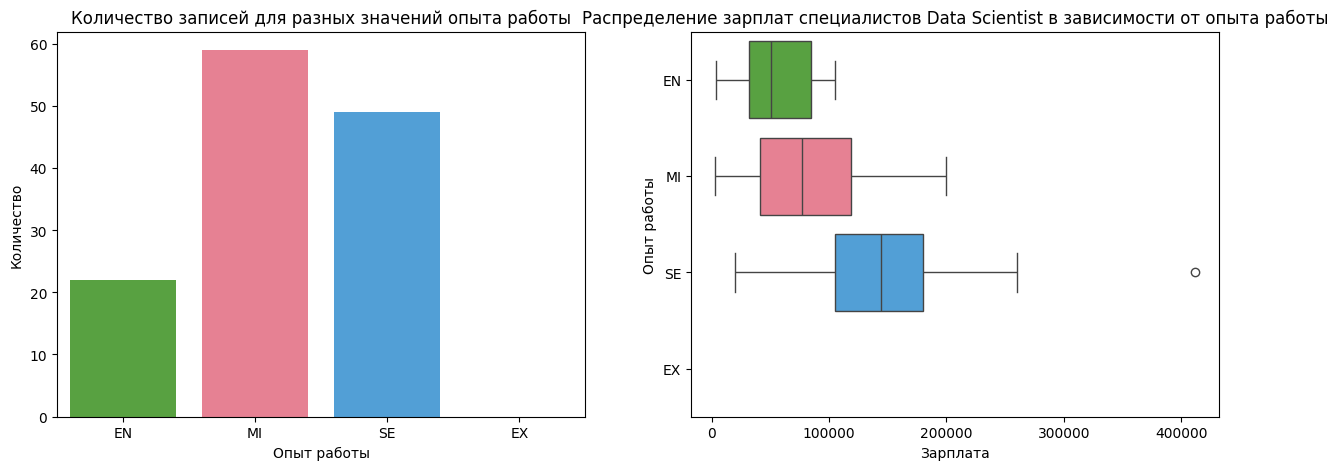

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=ds,
    ax=axes[0], 
    x='experience_level',
    order=['EN', 'MI', 'SE', 'EX'], 
    hue='experience_level',  
    palette='husl',
    legend=False
    )
axes[0].set(xlabel='Опыт работы', ylabel='Количество')
axes[0].set_title('Количество записей для разных значений опыта работы')

boxplot = sns.boxplot(
    data=ds,
    ax=axes[1], 
    y='experience_level',
    order=['EN', 'MI', 'SE', 'EX'],
    x='salary_in_usd',
    orient='h',
    hue='experience_level',
    palette='husl',
    legend=False
)

axes[1].set_title('Распределение зарплат специалистов Data Scientist в зависимости от опыта работы')
axes[1].set_xlabel('Зарплата')
axes[1].set_ylabel('Опыт работы')

plt.show()

Зависимость зарплат от опыта работы выглядит на первый взгляд ожидаемой - зароботная плата растёт с увеличением опыта. Позиция с зарплатой выше `400000` попала в `Senior-level/Expert`. Нужно отметить, что среди специалистов Data Scientist по какой-то причине не оказалось позиций соответстующих уровню `Executive-level/Director`.

##### 2.1d Распределение зарплат специалистов Data Scientist в зависимости от типа занятости

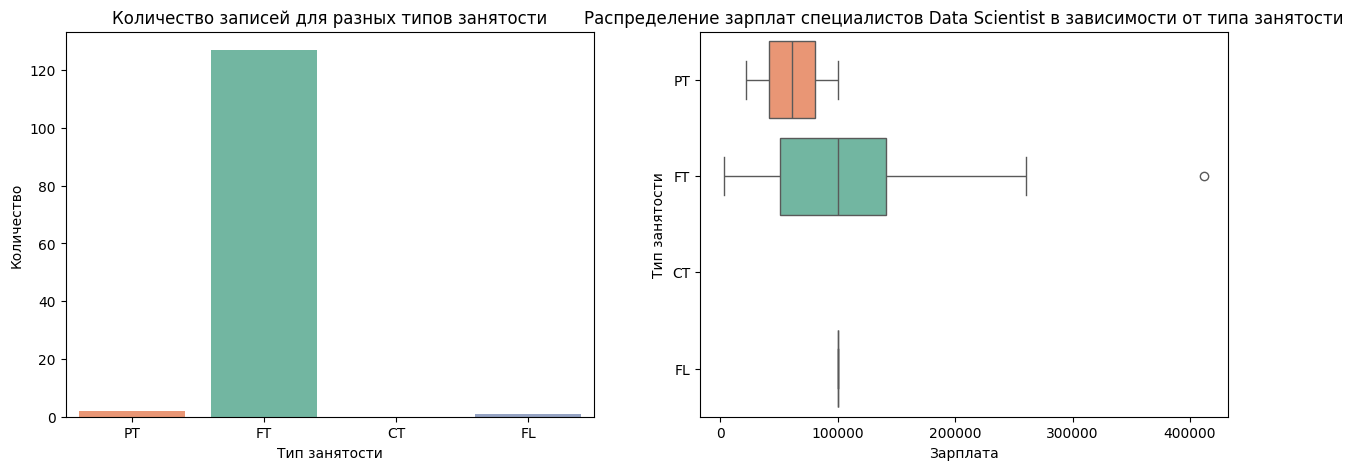

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=ds,
    ax=axes[0], 
    x='employment_type',
    order=['PT', 'FT', 'CT', 'FL'],
    hue='employment_type',
    palette='Set2',
    legend=False
    )
axes[0].set(xlabel='Тип занятости', ylabel='Количество')
axes[0].set_title('Количество записей для разных типов занятости')

boxplot = sns.boxplot(
    data=ds,
    ax=axes[1],
    y='employment_type',
    order=['PT', 'FT', 'CT', 'FL'],
    x='salary_in_usd',
    orient='h',
    hue='employment_type',
    palette='Set2',
    legend=False
)

axes[1].set_title('Распределение зарплат специалистов Data Scientist в зависимости от типа занятости')
axes[1].set_xlabel('Зарплата')
axes[1].set_ylabel('Тип занятости')

plt.show()

Почти все позиции имеют занятость `полный рабочий день`, а работающих по контракту нет вообще. Поэтому при такой выборке нельзя сделать вывод о зависимости заработной платы от типа занятости.

##### 2.1e
Признак `salary_currency` нет смысла подробно исследовать, т.к. он должен сильно коррелировать с `company_location` и `employee_residence`, но при этом данные в нём будут менее ценными из-за того, что несколько стран могут использовать одну и ту же валюту, как в случае с евро в странах Европы. Но и с этими двумя признаками проблема, т.к. к большинству стран относится, в лучшем случае, по одной записи, а основная масса приходится на США и немного на Соединённое королевство.

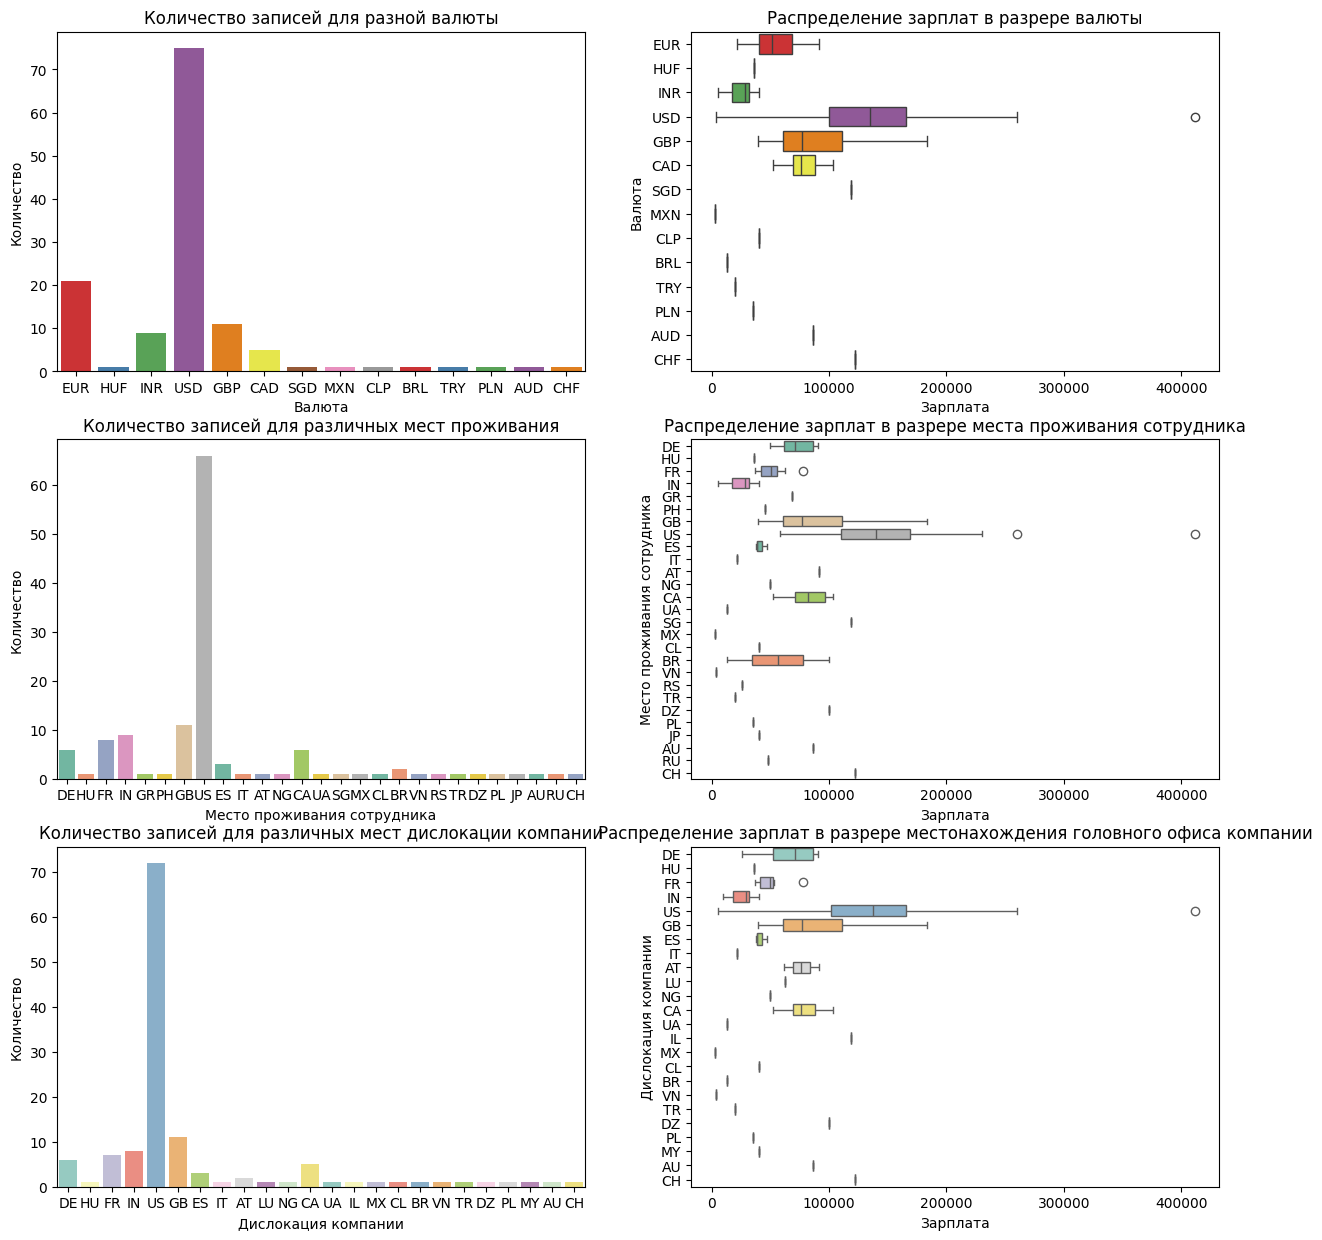

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.countplot(
    data=ds,
    ax=axes[0,0], 
    x='salary_currency',
    hue='salary_currency',
    palette='Set1',
    legend=False
    )
axes[0,0].set(xlabel='Валюта', ylabel='Количество')
axes[0,0].set_title('Количество записей для разной валюты')

sns.boxplot(
    data=ds,
    ax=axes[0,1],
    y='salary_currency',
    x='salary_in_usd',
    orient='h',
    hue='salary_currency',
    palette='Set1',
    legend=False
)
axes[0,1].set(xlabel='Зарплата', ylabel='Валюта')
axes[0,1].set_title('Распределение зарплат в разрере валюты')

sns.countplot(
    data=ds,
    ax=axes[1,0], 
    x='employee_residence',
    hue='employee_residence',
    palette='Set2',
    legend=False
    )
axes[1,0].set(xlabel='Место проживания сотрудника', ylabel='Количество')
axes[1,0].set_title('Количество записей для различных мест проживания')

sns.boxplot(
    data=ds,
    ax=axes[1,1],
    y='employee_residence',
    x='salary_in_usd',
    orient='h',
    hue='employee_residence',
    palette='Set2',
    legend=False
)
axes[1,1].set(xlabel='Зарплата', ylabel='Место проживания сотрудника')
axes[1,1].set_title('Распределение зарплат в разрере места проживания сотрудника')

sns.countplot(
    data=ds,
    ax=axes[2,0], 
    x='company_location',
    hue='company_location',
    palette='Set3',
    legend=False
    )
axes[2,0].set(xlabel='Дислокация компании', ylabel='Количество')
axes[2,0].set_title('Количество записей для различных мест дислокации компании')

sns.boxplot(
    data=ds,
    ax=axes[2,1],
    y='company_location',
    x='salary_in_usd',
    orient='h',
    hue='company_location',
    palette='Set3',
    legend=False
)
axes[2,1].set(xlabel='Зарплата', ylabel='Дислокация компании')
axes[2,1].set_title('Распределение зарплат в разрере местонахождения головного офиса компании')

plt.show()

В принципе, некоторые ожидаемые закономерности можно попытаться проследить, как те же высокие зарплаты для США и Великобритании и соответствующих валют, но из-за обилия единичных записей для большинства стран вряд ли можно установить чёткую взаимосвязь.

##### 2.1f Распределение зарплат специалистов Data Scientist в зависимости от объёма работы, выполняемой удалённо

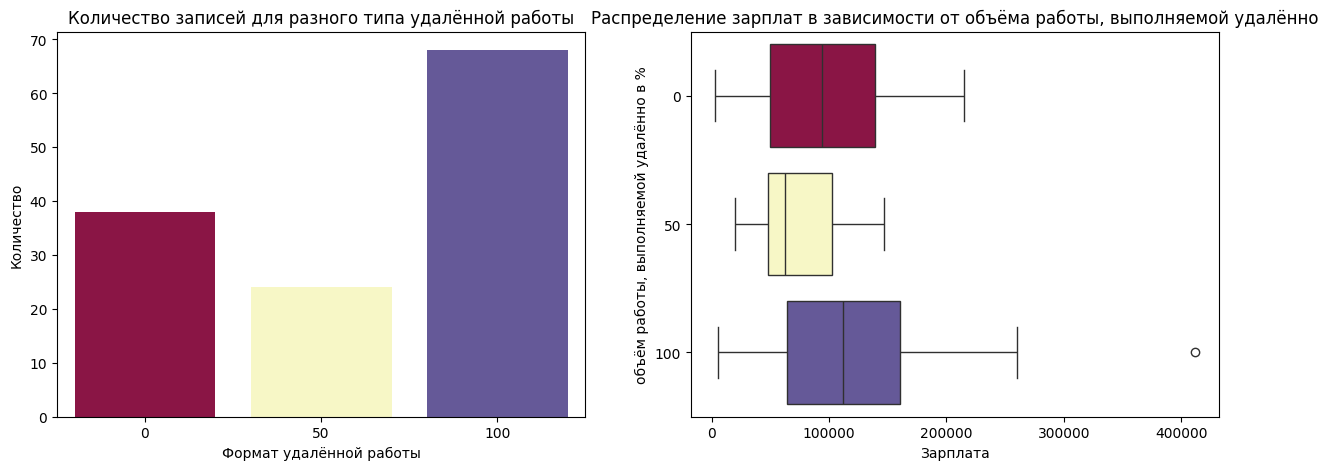

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=ds,
    ax=axes[0], 
    x='remote_ratio',
    hue='remote_ratio',
    palette='Spectral',
    legend=False
    )
axes[0].set(xlabel='Формат удалённой работы', ylabel='Количество')
axes[0].set_title('Количество записей для разного типа удалённой работы')

sns.boxplot(
    data=ds,
    ax=axes[1], 
    y='remote_ratio',
    x='salary_in_usd',
    orient='h',
    hue='remote_ratio',
    palette='Spectral',
    legend=False
)
axes[1].set_title('Распределение зарплат в зависимости от объёма работы, выполняемой удалённо')
axes[1].set_xlabel('Зарплата')
axes[1].set_ylabel('объём работы, выполняемой удалённо в %')

plt.show()

Выглядит так, что заработная плата при частично удалённой работе меньше, чем в остальных случаях.

##### 2.1g Распределение зарплат специалистов Data Scientist в зависимости от размера компании

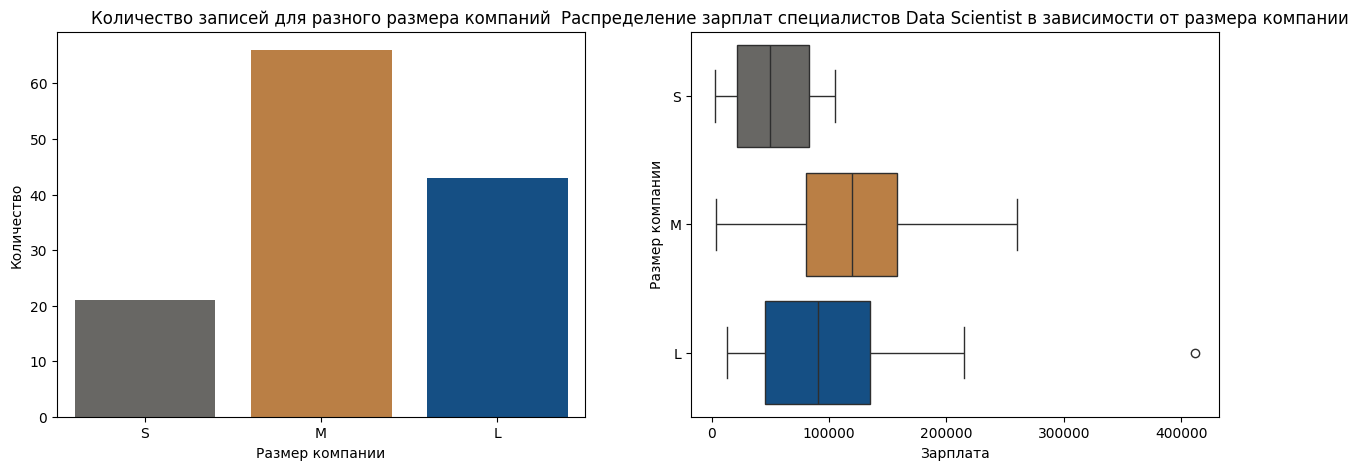

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=ds,
    ax=axes[0], 
    x='company_size',
    order=['S', 'M', 'L'],
    hue='company_size',
    palette='blend:#035096,#cd7f32',
    legend=False
    )
axes[0].set(xlabel='Размер компании', ylabel='Количество')
axes[0].set_title('Количество записей для разного размера компаний')

sns.boxplot(
    data=ds,
    ax=axes[1], 
    y='company_size',
    order=['S', 'M', 'L'],
    x='salary_in_usd',
    orient='h',
    hue='company_size',
    palette='blend:#035096,#cd7f32',
    legend=False
)

axes[1].set_title('Распределение зарплат специалистов Data Scientist в зависимости от размера компании')
axes[1].set_xlabel('Зарплата')
axes[1].set_ylabel('Размер компании')

plt.show()

Опять не наблюдается линейный рост. Самые большие зарплаты в среднем в компаниях, насчитывающих от 50 до 250 сотрудников.

##### Теперь, исследовав, как различные признаки влияют на зарплату, можно перейти к непосредственным вопросам. Предварительные ответы на первый "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?"  и третий "Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?" были получены.

##### 2.1h Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


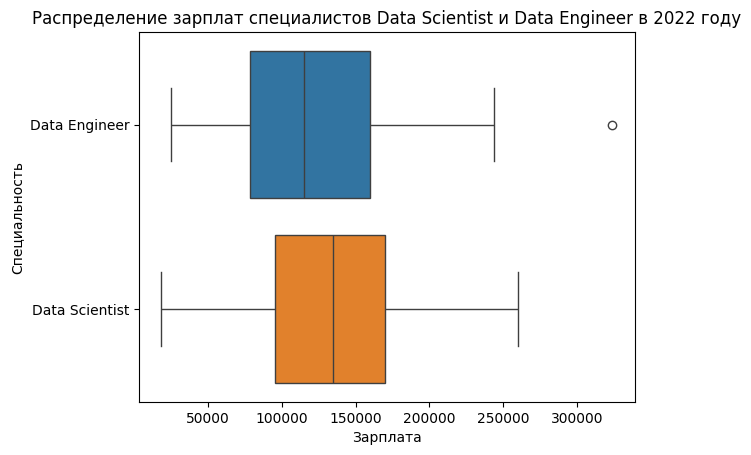

In [16]:
# фильтруем данные по специальностям и году
filtered_data = data[(data['job_title'].isin(['Data Scientist', 'Data Engineer'])) & (data['work_year']==2022)]

fig = sns.boxplot(
    filtered_data, 
    x='salary_in_usd', 
    y='job_title', 
    orient='h', 
    hue='job_title',
    legend=False
    )
fig.set(xlabel='Зарплата', ylabel='Специальность')
plt.title('Распределение зарплат специалистов Data Scientist и Data Engineer в 2022 году')

plt.show()

Видно, что зарплата специалистов Data Scientist несколько выше, как и разброс значений. У Data Engineer есть одно значение похожее на потенциальный выброс.

##### 2.1i Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Создадим дополнительный признак, показывающий, является ли должность Data Scientist или Data Engineer.

In [17]:
data['Is Data Scientist or Data Engineer'] = data['job_title'].apply(lambda x: 1 if x=='Data Scientist' else (2 if x=='Data Engineer' else 0))

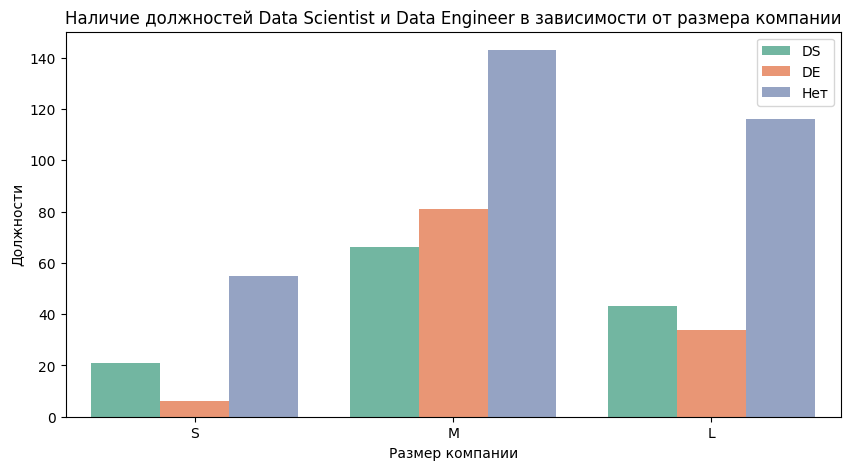

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=data,
    x='company_size',
    order=['S', 'M', 'L'],
    hue='Is Data Scientist or Data Engineer',
    hue_order=[1, 2, 0],
    palette='Set2'
    )
ax.set(xlabel='Размер компании', ylabel='Должности')
ax.legend(['DS', 'DE', 'Нет'])
plt.title('Наличие должностей Data Scientist и Data Engineer в зависимости от размера компании')
plt.show()

Можно предположить, что некоторая связь есть, при этом для Data Engineer она явно выражена сильнее. Для Data Scientist на первый взгляд количество должностей примерно пропорционально общему количеству записей.

#### 2.2. Статистический анализ данных

##### 2.2a Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

В этом пункте не очень понятно, что именно имеется в виду. Для трёх независымых выборок вроде бы предполагается использовать ANOVA или критерий Краскела — Уоллиса, но они покажут только статистическую значимость в разнице медиан. Непонятно, может быть нужно попарно сравнить зарплаты в разные года. Но попробуем оттолкнуться пока от этих критериев.

*Нулевая гипотеза*: размер заработной платы не отличается в разные года: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы отличается в разные года: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

In [19]:
# задаём уровень значимости
alpha = 0.05 

# создаём словарь с ключами - названиями выборок и значениями - выборками
salaries = {}
for year in list(ds['work_year'].unique()):
    salaries['salary_' + str(year)] = list(ds[ds['work_year']==year]['salary_in_usd'])
    # проверяем на нормальность
    _, p = stats.shapiro(salaries['salary_' + str(year)])
    print(year,'p-value = %.3f' % (p), sep='\n')
    if p <= alpha:
        print('Распределение не нормальное\n')
    else:
        print('Распределение нормальное\n')
        
# создаём выборки из словаря        
locals().update(salaries)

2020
p-value = 0.000
Распределение не нормальное

2021
p-value = 0.107
Распределение нормальное

2022
p-value = 0.676
Распределение нормальное



Т.к. одна из выборок не распределена нормально, применим критерий Краскела — Уоллиса.

In [20]:
alpha = 0.05 

_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Вывод: размер заработной платы отличается в разные года. Но на всякий случай сравним попарно выборки 2020-2021 и 2021-2022. Для первой пары воспользуемся критерием Манна - Уитни.

In [21]:
alpha = 0.05 

_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [22]:
# проводим тест Левена на равенство дисперсий
result = stats.levene(salary_2022, salary_2021)
p = result[1]
print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


Т.к. дисперсии одинаковы, можно воспользоваться Двухвыборочным t-критерием.

In [23]:
_, p = stats.ttest_ind(salary_2022, salary_2021, alternative='greater', equal_var=True)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


В принципе подтвердилась гипотеза, сделанная на этапе визуального анализа. Уровень зарплат в 2022 году однозначно выше 2021. Но про 2021 и 2020 однозначно сказать нельзя. Но в целом за 2 года уровень зарплат действительно вырос.

##### 2.2b Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Во время визуального анализа предположили, что зарплата Data Scientist выше, чем Data Engineer.

*Нулевая гипотеза*: размер заработной платы Data Scientist ($μ_1$) ниже или равен Data Engineer ($μ_2$) в 2022 году.

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы Data Scientist ($μ_1$) выше, чем Data Engineer ($μ_2$) в 2022 году.

$$ H_1 : μ_1 > μ_2 $$

In [24]:
salary_DS_2022 = list(data[(data['work_year']==2022) & (data['job_title']=='Data Scientist')]['salary_in_usd'])
salary_DE_2022 = list(data[(data['work_year']==2022) & (data['job_title']=='Data Engineer')]['salary_in_usd'])

# проверяем на нормальность
_, p = stats.shapiro(salary_DS_2022)
print('Data Scientist','p-value = %.3f' % (p), sep='\n')
if p <= alpha:
    print('Распределение не нормальное\n')
else:
    print('Распределение нормальное\n')
    
_, p = stats.shapiro(salary_DE_2022)
print('Data Engineer','p-value = %.3f' % (p), sep='\n')
if p <= alpha:
    print('Распределение не нормальное\n')
else:
    print('Распределение нормальное\n')

Data Scientist
p-value = 0.676
Распределение нормальное

Data Engineer
p-value = 0.007
Распределение не нормальное



Т.к. распределение в одной из выборок отлично от нормального, придётся использовать U-критерий Манна — Уитни

In [25]:
_, p = stats.mannwhitneyu(salary_DS_2022, salary_DE_2022, alternative='greater')

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Тест показал, что кажущееся на графике превосходство зарплат специалистов Data Scientist над Data Engineer статистически не значимо. Проверим есть ли вообще между ними статистически значимая разница.

In [26]:
# Используем двустороннюю проверку
_, p = stats.mannwhitneyu(salary_DS_2022, salary_DE_2022, alternative='two-sided')

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Тест показал, что разница зарплат специалистов Data Scientist и Data Engineer в 2022 году статистически не значима.

##### 2.2c ак соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Из визуального анализа можно предположить, самые высокие зарплаты в компаниях среднего размера, а самые низкие в небольших.

In [27]:
# создаём выборки зарплат для разного размера компаний
salaries_cs = {}
for size in list(ds['company_size'].unique()):
    salaries_cs['salary_' + size] = list(ds[ds['company_size']==size]['salary_in_usd'])
    # проверяем на нормальность
    _, p = stats.shapiro(salaries_cs['salary_' + size])
    print(size,'p-value = %.3f' % (p), sep='\n')
    if p <= alpha:
        print('Распределение не нормальное\n')
    else:
        print('Распределение нормальное\n')
        
# создаём выборки из словаря        
locals().update(salaries_cs)

L
p-value = 0.000
Распределение не нормальное

S
p-value = 0.189
Распределение нормальное

M
p-value = 0.897
Распределение нормальное



Для начала применим критерий Красела - Уоллеса, т.к. у одной из групп рапределение отлично от нормального.

*Нулевая гипотеза*: размер заработной платы не отличается в компаниях разных размеров: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер заработной платы отличается в компаниях разных размеров: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

In [31]:
alpha = 0.05 

_, p = stats.kruskal(salary_S, salary_M, salary_L)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Заработная плата ожидаемо отличается.

Теперь стоит попарно сравнить S-L и L-M. К сожалению, т.к. в каждой из пар присутствуют данны не распределённые нормально, придётся использовать параметрический критерий.

*Нулевая гипотеза*: размер заработной платы в больших компаниях (L) ($μ_1$) ниже или равен зарплатам в небольших компаниях (S) ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в больших компаниях (L) ($μ_1$) выше, чем небольших компаниях (S) ($μ_2$).

$$ H_1 : μ_1 > μ_2 $$

In [35]:
# сравниваем S и L
_, p = stats.mannwhitneyu(salary_L, salary_S, alternative='greater')

print('L-S','p-value = %.3f' % (p), sep='\n')

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha),'\n')
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha),'\n')

L-S
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу. 



*Нулевая гипотеза*: размер заработной платы в средних компаниях (M) ($μ_1$) ниже или равен зарплатам в больших компаниях (L) ($μ_2$).

$$ H_0 : μ_1 <= μ_2 $$

*Альтернативная гипотеза*: размер заработной платы в средних компаниях (M) ($μ_1$) выше, чем больших компаниях (L) ($μ_2$).

$$ H_1 : μ_1 > μ_2 $$

In [36]:
# сравниваем L и M    
_, p = stats.mannwhitneyu(salary_M, salary_L, alternative='greater')

print('M-L','p-value = %.3f' % (p), sep='\n')

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha),'\n')
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha),'\n')    

M-L
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу. 



Таким образом, подтвердили первоначальную гипотезу, сделанную после визуального анализа. Самые высокие зарплаты в компаниях среднего размера, затем идут большие, затем небольшие.

##### 2.2d Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Здесь вопрос не до конца однозначен и, возможно, зависит от того, как именно считать. Имеется ли ввиду связь между наличием какой-то из указанных должностей или каждой конкретной. Можно считать отдельно для каждой специальности или вместе, результаты, возможно будут разными.

В любом случа придётся использовать критерий хи-квадрат. Гипотезы во всех случаях будут идентичны.

*Нулевая гипотеза*: связи между наличием должности/должностей и размером компании нет: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: связь между наличием должности/должностей и размером компании есть: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$

In [40]:
cross_tab = pd.crosstab(data['Is Data Scientist or Data Engineer'], data['company_size'])
cross_tab

company_size,L,M,S
Is Data Scientist or Data Engineer,,,
0,116,143,55
1,43,66,21
2,34,81,6


In [41]:
_, p, _, _ = stats.chi2_contingency(cross_tab)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Про использоване критеря хи-квадрат для трёх признаков и трёх выборок не было сказано в учебном материале, но если предположить, что здесь он применён корректно, то из теста следует, что зависимость есть.

Проверим это для ситуации, когда специальности учитываются вместе.

In [43]:
# бинарный признак показывающий, является ли специальность DS или DE
data['DS or DE'] = data['Is Data Scientist or Data Engineer'].apply(lambda x: 1 if x!=0 else 0)
cross_tab_2 = pd.crosstab(data['DS or DE'], data['company_size'])
cross_tab_2

company_size,L,M,S
DS or DE,,,
0,116,143,55
1,77,147,27


In [44]:
_, p, _, _ = stats.chi2_contingency(cross_tab_2)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


В это случае также показана зависимость.

Проверим отдельно для каждой специальности.

In [49]:
# создаём бинарный признак для Data Scientis
data['Is Data Scientist'] = data['job_title'].apply(lambda x: 1 if x=='Data Scientist' else 0)
cross_tab_DS = pd.crosstab(data['Is Data Scientist'], data['company_size'])
display(cross_tab_DS)

_, p, _, _ = stats.chi2_contingency(cross_tab_DS)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

company_size,L,M,S
Is Data Scientist,,,
0,150,224,61
1,43,66,21


p-value = 0.826
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [50]:
# создаём бинарный признак для Data Engineer
data['Is Data Engineer'] = data['job_title'].apply(lambda x: 1 if x=='Data Engineer' else 0)
cross_tab_DE = pd.crosstab(data['Is Data Engineer'], data['company_size'])
display(cross_tab_DE)

_, p, _, _ = stats.chi2_contingency(cross_tab_DE)

print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

company_size,L,M,S
Is Data Engineer,,,
0,159,209,76
1,34,81,6


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


А вот если смотреть на каждую специальность по отдельности, то вывод получается такой же, какой был сделан при визуальном анализе. Между наличием должности Data Engineer и размером компании связь есть, а для Data Scientist такой связи не наблюдается.

---

### 3. Соответствие выводов бизнес-вопросам

##### 3.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Уровень зарплат в 2022 году выше, чем в предыдущие. Но из-за слова "ежегодный" на вопрос нельзя однозначно ответить, т.к. тесты не показали статистически значимого роста зарплат в 2021 по сравнению с 2020. Но в целом, наверное, можно было бы сказать, что скорее "да".

##### 3.2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
Скорее всего на результат влияет выброс в данных у Data Engineer и если его отбросить, то результат был бы другим. Но для изначальных данных тест показал, что разница зарплат для Data Scientist и Data Engineer в 2022 году статистически не значима.

##### 3.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
Самые высокие зарплаты специалистов Data Scientist в компаниях среднего размера, на втором месте зарплаты в больших компаниях и самые низкие в небольших.

##### 3.4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
Обнаружена связь между размером компании и наличием должностей Data Scientist или Data Engineer. Отдельно связи между наличием должности Data Scientist и размером компании нет, но есть для должности Data Engineer.

---

### 4. Дополнительное исследование